# Video Scene Detection based on Optimal Sequential Grouping

Some examples on synthetic data

In [1]:
import time
from typing import Tuple, List
from multiprocessing import Pool

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from h_add import get_optimal_sequence_add
from h_nrm import get_optimal_sequence_nrm
from estimate_scenes_count import estimate_scenes_count
from evaluation import calculate_interval_metric

%matplotlib inline

Helper functions:

In [2]:
class data_linewidth_plot():
    """
    Draws lines that could scale along with figure size
    Source: https://stackoverflow.com/questions/19394505/matplotlib-expand-the-line-with-specified-width-in-data-unit/42972469#42972469
    """
    def __init__(self, x, y, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.fig = self.ax.get_figure()
        self.lw_data = kwargs.pop("linewidth", 1)
        self.lw = 1
        self.fig.canvas.draw()

        self.ppd = 72./self.fig.dpi
        self.trans = self.ax.transData.transform
        self.linehandle, = self.ax.plot([],[],**kwargs)
        if "label" in kwargs: kwargs.pop("label")
        self.line, = self.ax.plot(x, y, **kwargs)
        self.line.set_color(self.linehandle.get_color())
        self._resize()
        self.cid = self.fig.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self, event=None):
        lw =  ((self.trans((1, self.lw_data))-self.trans((0, 0)))*self.ppd)[1]
        if lw != self.lw:
            self.line.set_linewidth(lw)
            self.lw = lw
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.fig.canvas.draw_idle())
        self.timer.start()

        
def plot_distances_chart(distances: np.ndarray, scene_borders: np.ndarray, ax: matplotlib.axes.Axes) -> None:
    """
    Plot scene borders on top of the pairwise distances matrix

    :param distances: pairwise distances matrix
    :param scene_borders:
    """
    ax.imshow(distances, cmap='gray')
    borders_from_zero = np.concatenate(([0], scene_borders))
    for i in range(1, len(borders_from_zero)):    
        data_linewidth_plot(
            x=[borders_from_zero[i-1], borders_from_zero[i-1]],
            y=[borders_from_zero[i-1], borders_from_zero[i]],
            ax=ax, linewidth=1,
            color='red',
            alpha=0.5
        )
        data_linewidth_plot(
            x=[borders_from_zero[i-1], borders_from_zero[i]],
            y=[borders_from_zero[i-1], borders_from_zero[i-1]],
            ax=ax, linewidth=1,
            color='red',
            alpha=0.5
        )
        data_linewidth_plot(
            x=[borders_from_zero[i-1], borders_from_zero[i]],
            y=[borders_from_zero[i], borders_from_zero[i]],
            ax=ax,
            linewidth=1,
            color='red',
            alpha=0.5
        )
        data_linewidth_plot(
            x=[borders_from_zero[i], borders_from_zero[i]],
            y=[borders_from_zero[i-1], borders_from_zero[i]],
            ax=ax,
            linewidth=1,
            color='red',
            alpha=0.5
        )

        
def get_synth_example(
    features_count: int,
    scenes_count: int,
    random_seed: int = 42
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates synthetic pairwise distance matrix for features_count shots and scenes_count scenes
    
    :param features_count: count of shots
    :param scenes_count: count of diagonal clusters represented scenes
    :param random_seed: value for random numbers generator initialization
    :return: pairwise distance matrix and scene borders
    """
    synth_distances = np.random.uniform(size=(features_count, features_count))
    np.random.seed(random_seed)
    random_t = np.random.choice(range(2, features_count - 1), size=scenes_count-1, replace=False)
    random_t.sort()
    for i, t in enumerate(random_t):
        if i == 0:
            synth_distances[0:t, 0:t] = np.clip(synth_distances[0:t, 0:t] - 0.4, 0., 1.)
        else:
            synth_distances[random_t[i - 1]:t, random_t[i - 1]:t] = \
                np.clip(synth_distances[random_t[i - 1]:t, random_t[i - 1]:t] - 0.4, 0., 1.)
    synth_distances[random_t[-1]:features_count, random_t[-1]:features_count] = \
        np.clip(synth_distances[random_t[-1]:features_count, random_t[-1]:features_count] - 0.4, 0., 1.)
    random_t = np.append(random_t, [features_count])
    synth_distances = (synth_distances + synth_distances.T)/2

    np.fill_diagonal(synth_distances, 0)
    return synth_distances, random_t - 1

def get_intervals_from_borders(borders: np.ndarray) -> List[List[Tuple[int, int]]]:
    """
    Convert scene borders to intervals
    
    :param borders: list of borders
    :return: list of interval tuples where first value - beginning of an interval, the second - end of an interval
    """
    intervals = []
    prev_border = 0
    for cur_border in borders:
        intervals.append((prev_border, cur_border))
        prev_border = cur_border
    return intervals

## Additive Cost Function

Let's generate random pairwise distances matrix, add some uniform noise and calculate optimal borders accordingly to Additive Cost Function.

Text(0.5, 1.0, 'Predicted Borders')

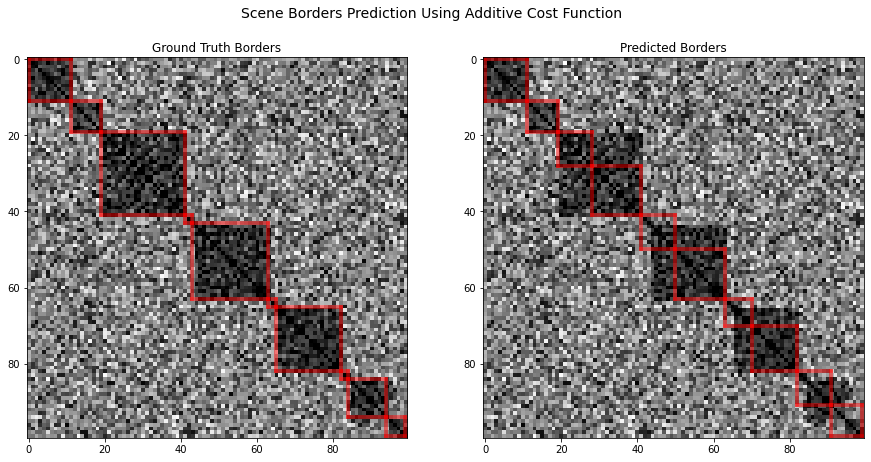

In [3]:
shots_count = 100
scenes_count = 10
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
optimal_scene_borders = get_optimal_sequence_add(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,7))
figs.suptitle('Scene Borders Prediction Using Additive Cost Function', fontsize=14)
plot_distances_chart(distances, synth_scene_borders, axs[0])
axs[0].set_title('Ground Truth Borders')
plot_distances_chart(distances, optimal_scene_borders, axs[1])
axs[1].set_title('Predicted Borders')

## Normalized Cost Function

Let's generate random pairwise distances matrix, add some uniform noise and calculate optimal borders accordingly to Normalized Cost Function.

Text(0.5, 1.0, 'Predicted Borders')

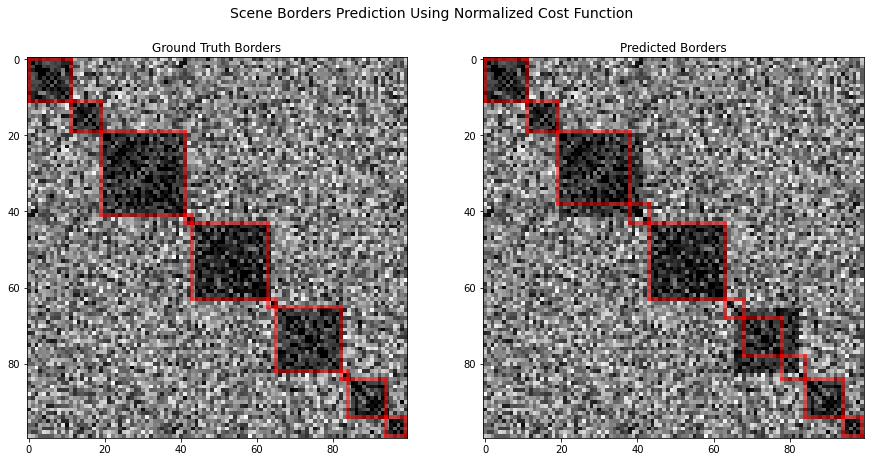

In [4]:
shots_count = 100
scenes_count = 10
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
optimal_scene_borders = get_optimal_sequence_nrm(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,7))
figs.suptitle('Scene Borders Prediction Using Normalized Cost Function', fontsize=14)
plot_distances_chart(distances, synth_scene_borders, axs[0])
axs[0].set_title('Ground Truth Borders')
plot_distances_chart(distances, optimal_scene_borders, axs[1])
axs[1].set_title('Predicted Borders')

As you can see, Additive Const Function works a little bit worse than Normalized Cost Function. But one example is not enough.

## Quality Tests

Let's generate 999 synthetic examples and check both algorithm's quality on several metrics.

In [5]:
test_examples = []
for N in range(12, 123):
    for K in range(2,11):
        test_examples.append(get_synth_example(N, K))

Find optimal borders for each example with Hadd optimisation:

In [6]:
predicted_examples_add = []
def predict_examples_add(args):
    distances, synth_scene_borders = args
    K = estimate_scenes_count(distances)
    return get_optimal_sequence_add(distances, K)

with Pool(4) as pool:
    predicted_examples_add = list(tqdm(pool.imap(predict_examples_add, test_examples), total=len(test_examples)))

100%|██████████| 999/999 [00:33<00:00, 30.17it/s]  


Find optimal borders for each example with Hnrm optimisation:

In [7]:
predicted_examples_nrm = []
def predict_examples_nrm(args):
    distances, synth_scene_borders = args
    K = estimate_scenes_count(distances)
    return get_optimal_sequence_nrm(distances, K)

with Pool(4) as pool:
    predicted_examples_nrm = list(tqdm(pool.imap(predict_examples_nrm, test_examples), total=len(test_examples)))

100%|██████████| 999/999 [20:13<00:00,  1.21s/it]  


Convert scene borders to intervals:

In [8]:
predicted_intervals_add = []
for example in predicted_examples_add:
    predicted_intervals_add.append(get_intervals_from_borders(example))
    
predicted_intervals_nrm = []
for example in predicted_examples_nrm:
    predicted_intervals_nrm.append(get_intervals_from_borders(example))
        
gt_intervals = []
for distances, synth_scene_borders in test_examples:
    gt_intervals.append(get_intervals_from_borders(synth_scene_borders))

Get mean precision, recall, F1 and IoU for each result:

In [9]:
precision_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'precision')
recall_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'recall')
f1_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'f1')
iou_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'iou')

In [10]:
precision_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'precision')
recall_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'recall')
f1_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'f1')
iou_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'iou')

In [11]:
print('Precision add: {} Precision nrm: {}'.format(precision_add, precision_nrm))
print('Recall add: {} Recall nrm: {}'.format(recall_add, recall_nrm))
print('F1 add: {} F1 nrm: {}'.format(f1_add, f1_nrm))
print('IoU add: {} IoU nrm: {}'.format(iou_add, iou_nrm))

Precision add: 0.5006426351857141 Precision nrm: 0.5453283464041074
Recall add: 0.9632476338594912 Recall nrm: 0.986827773742529
F1 add: 0.5660577608586743 F1 nrm: 0.6165629629736262
IoU add: 0.47188725622059907 IoU nrm: 0.5369531996674883


As we can see, optimisation of the Hnrm metrics works better than Hadd accordingly to each mertics.

## Time Tests

But what about speed?

Let's fix scenes count K, and see, how optimization time depends on shots count N:

In [12]:
test_data = []
K = 5
Ns = range(10, 100)
for N in Ns:
    test_data.append(get_synth_example(N, K))
ns_add_times = []
ns_nrm_times = []
for distances, synth_scene_borders in test_data:
    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_add(distances, K)
    ns_add_times.append(time.time() - start_time)

    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_nrm(distances, K)
    ns_nrm_times.append(time.time() - start_time)

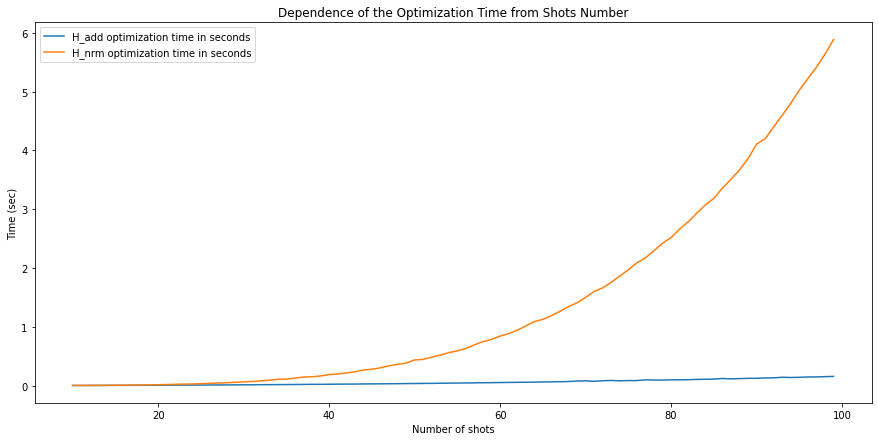

In [13]:
plt.figure(figsize=(15,7))
ax = plt.gca()
ax.plot(Ns, ns_add_times, label='H_add optimization time in seconds')
ax.plot(Ns, ns_nrm_times, label='H_nrm optimization time in seconds')
ax.set(title='Dependence of the Optimization Time from Shots Number', ylabel='Time (sec)', xlabel='Number of shots')
ax.legend(loc='best') 

In one more test we'll fix count of shots N, and see how optimization time depends on scenes count K:

In [14]:
test_data = []
N = 70
Ks = range(2, 12)
for K in Ks:
    test_data.append(get_synth_example(N, K))
ks_add_times = []
ks_nrm_times = []
for distances, synth_scene_borders in test_data:
    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_add(distances, len(synth_scene_borders))
    ks_add_times.append(time.time() - start_time)

    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_nrm(distances, len(synth_scene_borders))
    ks_nrm_times.append(time.time() - start_time)

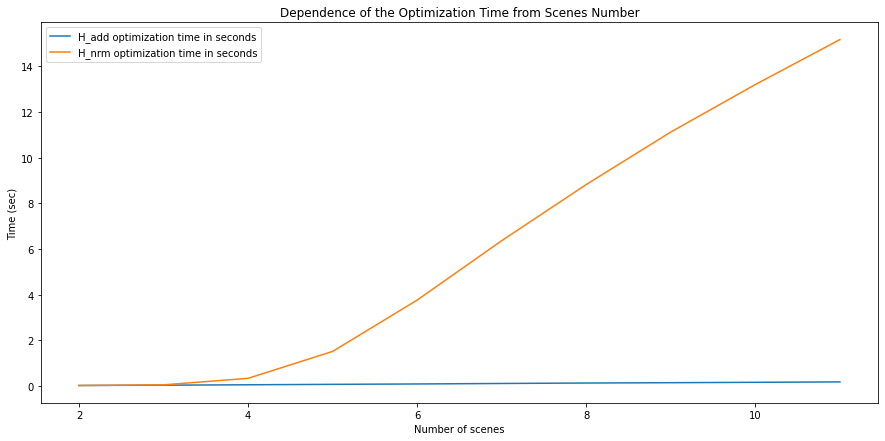

In [15]:
plt.figure(figsize=(15,7))
ax = plt.gca()
ax.plot(Ks, ks_add_times, label='H_add optimization time in seconds')
ax.plot(Ks, ks_nrm_times, label='H_nrm optimization time in seconds')
ax.set(title='Dependence of the Optimization Time from Scenes Number', ylabel='Time (sec)', xlabel='Number of scenes')
ax.legend(loc='best') 

In both experiments we can see, that optimisation process of the Hnrm way more slower than optimisation of the Hadd.

Real world tasks offer much higher values of both N and K, so for now we cannot use Hnrm despite it's higher accuracy.